In [1]:
import os
from pathlib import Path

import numpy as np
from PIL import Image
from skimage import color

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

# Load and explore data

In [2]:
GRAYSCALE_PATH = "/kaggle/input/image-colorization/l/gray_scale.npy"
AB_1_PATH = "/kaggle/input/image-colorization/ab/ab/ab1.npy"
AB_2_PATH = "/kaggle/input/image-colorization/ab/ab/ab2.npy"
AB_3_PATH = "/kaggle/input/image-colorization/ab/ab/ab3.npy"

In [3]:
# --------------------------------------
# 1. Dataset
# --------------------------------------
class Coco25kColorizationDataset(Dataset):
    def __init__(self, txt_file, image_dir, image_size=256):
        with open(txt_file, 'r') as f:
            lines = [l.strip() for l in f if l.strip()]
        self.paths = [Path(image_dir) / Path(l).name for l in lines]
        self.resize = transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # load & resize
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.resize(img)
        img_np = np.array(img, dtype=np.float32) / 255.0

        # RGB -> Lab
        lab = color.rgb2lab(img_np)  # HxWx3, L∈[0,100], a,b∈[-128,127]
        
        # normalize
        L  = lab[..., 0:1] / 100.0                   # -> [0,1]
        ab = (lab[..., 1:]) / 128.0                  # -> ~[-1,1]
        
        # to tensors CxHxW
        L  = torch.from_numpy(L).permute(2, 0, 1).float()
        ab = torch.from_numpy(ab).permute(2, 0, 1).float()
        return L, ab

In [4]:
# initialise dataset
dataset = Coco25kColorizationDataset(txt_file, GRAYSCALE_PATH, image_size)

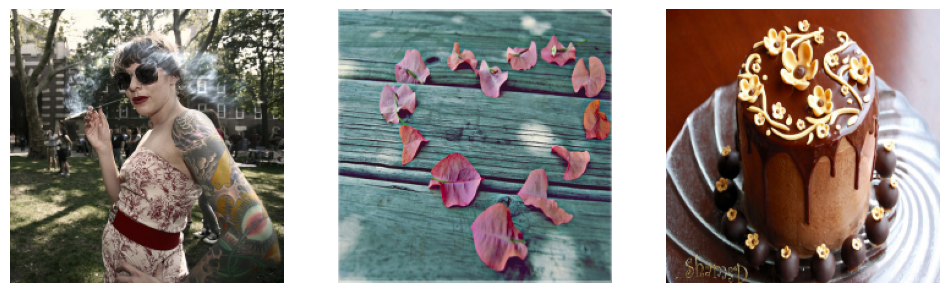

In [5]:
dataset.show_images(indices=[0, 1, 2])

# Model architecture

In [6]:
class CNN_Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # Encoder
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,2,1),       nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,128,3,1,1), nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,2,1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128,256,3,1,1), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,1,1), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,2,1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Dilated bottleneck
            nn.Conv2d(256, 512, kernel_size=3, stride=1, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Decoder
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,1,1),          nn.ReLU(inplace=True),
            nn.Conv2d(256,2,3,1,1),

            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        return self.layers(x)

# Train model

In [37]:
import re
import glob

def train_colorizer(
    txt_file,
    image_dir,
    out_dir='checkpoints',
    image_size=256,
    batch_size=64,
    lr=1e-3,
    epochs=20,
    val_split=0.3,
    test_split=0.5,
    resume=False
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(out_dir, exist_ok=True)

    # dataset + splits
    dataset = Coco25kColorizationDataset(txt_file, image_dir, image_size)
    indices = list(range(len(dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=val_split, random_state=42)
    val_idx, test_idx  = train_test_split(temp_idx, test_size=test_split, random_state=42)

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(Subset(dataset, val_idx),   batch_size=batch_size, shuffle=False, num_workers=4)

    # model, loss, optimizer
    model = CNN_Colorizer().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    start_epoch = 1

    # Resume logic
    if resume:
        checkpoint_files = glob.glob(os.path.join(out_dir, 'cnn_colorizer_epoch*.pth'))
        if checkpoint_files:
            latest_ckpt = max(checkpoint_files, key=os.path.getctime)
            print(f"Resuming from checkpoint: {latest_ckpt}")
            ckpt = torch.load(latest_ckpt, map_location=device)
            model.load_state_dict(ckpt['model_state'])
            optimizer.load_state_dict(ckpt['optimizer_state'])
            start_epoch = ckpt['epoch'] + 1
        else:
            print("No checkpoint found. Starting from scratch.")

    # --- Training Loop ---
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Train")
        for L, ab in train_pbar:
            L, ab = L.to(device), ab.to(device)
            ab_pred = model(L)
            ab_pred = nn.functional.interpolate(ab_pred, size=L.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(ab_pred, ab)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * L.size(0)
            train_pbar.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)

        # --- validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for L, ab in tqdm(val_loader, desc=f"[Epoch {epoch}/{epochs}] Val  "):
                L, ab = L.to(device), ab.to(device)
                ab_pred = model(L)
                ab_pred = nn.functional.interpolate(ab_pred, size=L.shape[-2:], mode='bilinear', align_corners=False)
                val_loss += criterion(ab_pred, ab).item() * L.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch} — Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # --- checkpoint ---
        ckpt = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
        }
        torch.save(ckpt, os.path.join(out_dir, f'cnn_colorizer_epoch{epoch}.pth'))
        print(f"  → Saved checkpoint: {out_dir}/cnn_colorizer_epoch{epoch}.pth\n")


if __name__ == '__main__':
    # replace with your actual paths
    ds_path    = '/kaggle/input/coco25k'
    images_dir = os.path.join(ds_path, 'images')
    txt_file   = os.path.join(ds_path, 'coco25k.txt')

    train_colorizer(
        txt_file=txt_file,
        image_dir=images_dir,
        out_dir='checkpoints',
        image_size=256,
        batch_size=64,
        lr=1e-3,
        epochs=20,
        resume=True
    )


<ipython-input-37-b728baf09aa9>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(latest_ckpt, map_location=device)


Resuming from checkpoint: checkpoints/cnn_colorizer_epoch3.pth


[Epoch 4/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 4 — Train Loss: 0.0124 | Val Loss: 0.0127
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch4.pth



[Epoch 5/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 5 — Train Loss: 0.0123 | Val Loss: 0.0122
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch5.pth



[Epoch 6/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.84it/s]


Epoch 6 — Train Loss: 0.0121 | Val Loss: 0.0128
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch6.pth



[Epoch 7/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 7 — Train Loss: 0.0121 | Val Loss: 0.0131
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch7.pth



[Epoch 8/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.84it/s]


Epoch 8 — Train Loss: 0.0120 | Val Loss: 0.0130
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch8.pth



[Epoch 9/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 9 — Train Loss: 0.0119 | Val Loss: 0.0123
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch9.pth



[Epoch 10/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 10 — Train Loss: 0.0119 | Val Loss: 0.0135
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch10.pth



[Epoch 11/20] Val  : 100%|██████████| 59/59 [00:31<00:00,  1.85it/s]


Epoch 11 — Train Loss: 0.0118 | Val Loss: 0.0119
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch11.pth



[Epoch 12/20] Val  : 100%|██████████| 59/59 [00:31<00:00,  1.85it/s]


Epoch 12 — Train Loss: 0.0117 | Val Loss: 0.0117
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch12.pth



[Epoch 13/20] Val  : 100%|██████████| 59/59 [00:31<00:00,  1.85it/s]


Epoch 13 — Train Loss: 0.0114 | Val Loss: 0.0117
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch13.pth



[Epoch 14/20] Val  : 100%|██████████| 59/59 [00:33<00:00,  1.79it/s]


Epoch 14 — Train Loss: 0.0113 | Val Loss: 0.0134
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch14.pth



[Epoch 15/20] Val  : 100%|██████████| 59/59 [00:31<00:00,  1.85it/s]


Epoch 15 — Train Loss: 0.0112 | Val Loss: 0.0115
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch15.pth



[Epoch 16/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 16 — Train Loss: 0.0111 | Val Loss: 0.0113
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch16.pth



[Epoch 17/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.84it/s]


Epoch 17 — Train Loss: 0.0110 | Val Loss: 0.0113
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch17.pth



[Epoch 18/20] Val  : 100%|██████████| 59/59 [00:31<00:00,  1.85it/s]


Epoch 18 — Train Loss: 0.0109 | Val Loss: 0.0129
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch18.pth



[Epoch 19/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.83it/s]


Epoch 19 — Train Loss: 0.0108 | Val Loss: 0.0116
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch19.pth



[Epoch 20/20] Val  : 100%|██████████| 59/59 [00:32<00:00,  1.84it/s]

Epoch 20 — Train Loss: 0.0108 | Val Loss: 0.0108
  → Saved checkpoint: checkpoints/cnn_colorizer_epoch20.pth



Continue learning if needed

# Inference the model

In [123]:


def inference(input_gray_path, output_path, checkpoint, image_size=256, device=None):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

    model = CNN_Colorizer().to(device).eval()
    ckpt = torch.load(checkpoint, map_location=device)
    if isinstance(ckpt, dict) and 'model_state' in ckpt:
        model.load_state_dict(ckpt['model_state'])
    else:
        model.load_state_dict(ckpt)

    # 3. Load & preprocess L channel
    img = Image.open(input_gray_path).convert('L').resize((image_size, image_size), Image.BICUBIC)
    L = np.array(img, dtype=np.float32)             # HxW in [0..255]
    L = L / 255.0 * 100.0                           # scale to [0..100] (Lab L)
    L_norm = L / 100.0                              # normalize to [0..1]
    L_tensor = torch.from_numpy(L_norm).unsqueeze(0).unsqueeze(0).to(device)  # 1x1xHxW

    # 4. Predict ab
    with torch.no_grad():
        ab_pred = model(L_tensor)                                           # 1x2xhxw (h=image_size/4)
        ab_up = F.interpolate(ab_pred, size=L_tensor.shape[-2:], mode='bilinear', align_corners=False)
        ab_np = ab_up.squeeze(0).cpu().numpy().transpose(1, 2, 0)          # HxWx2

    # 5. Denormalize ab back to [-128,127]
    ab_denorm = ab_np * 128.0

    # 6. Reconstruct Lab image & convert to RGB
    lab_out = np.zeros((image_size, image_size, 3), dtype=np.float32)
    lab_out[..., 0] = L
    lab_out[..., 1:] = ab_denorm
    rgb_out = np.clip(color.lab2rgb(lab_out), 0.0, 1.0)  # floats in [0,1]

    # 7. Save
    rgb_img = Image.fromarray((rgb_out * 255).astype(np.uint8))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    rgb_img.save(output_path)
    print(f"Saved colorized image to {output_path}")

if __name__ == '__main__':
    ds_path      = '/kaggle/input/coco25k'
    input_gray   = os.path.join(ds_path, 'images', os.listdir(os.path.join(ds_path,'images'))[0]) # 6
    output_color = 'output/colorized.png'
    checkpoint   = 'checkpoints/cnn_colorizer_epoch3.pth'

    inference(input_gray, output_color, checkpoint)

    # Optional: display side-by-side
    import matplotlib.pyplot as plt
    orig = Image.open(input_gray).convert('RGB').resize((512,512))


Saved colorized image to output/colorized.png


<ipython-input-123-8c259def0af3>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint, map_location=device)


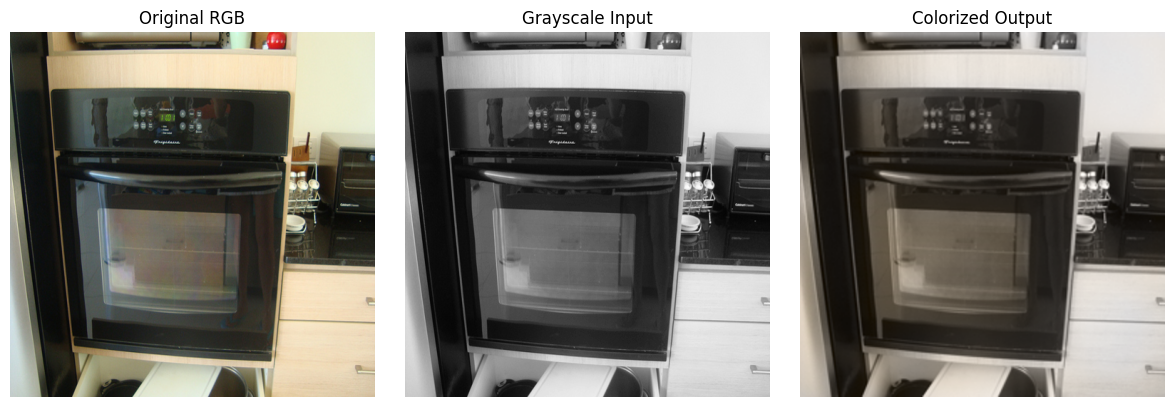

In [124]:
import matplotlib.pyplot as plt
from PIL import Image

# Load images
orig = Image.open(input_gray).convert('RGB').resize((512, 512))
gray = Image.open(input_gray).convert('L').resize((512, 512))  # grayscale version
gen  = Image.open(output_color).convert('RGB').resize((512, 512))

# Plot all three
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(orig)
axs[0].set_title('Original RGB')
axs[0].axis('off')

axs[1].imshow(gray, cmap='gray')
axs[1].set_title('Grayscale Input')
axs[1].axis('off')

axs[2].imshow(gen)
axs[2].set_title('Colorized Output')
axs[2].axis('off')

plt.tight_layout()
plt.show()


# Save the model if needed

In [115]:
from IPython.display import FileLink
import shutil

shutil.copy('checkpoints/cnn_colorizer_epoch20.pth', 'epoch20.pth')

# Create a clickable link
FileLink('epoch20.pth')


/kaggle/working/epoch20.pth